## Install Pyspark

In [1]:
!pip install pyspark
!pip install findspark

## Start Spark Session

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [3]:
sc = SparkContext()
spark = SparkSession.builder.appName("LogAnalysis").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/18 20:06:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/18 20:06:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/10/18 20:06:02 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## Transform Data and Load to CSV

In [4]:
import ast
from pyspark.sql.functions import *
from pyspark.sql.types import *

#Define extracted field list
field_list = {
    "Mac": StringType(),
    "SessionMainMenu": StringType(),
    "AppName": StringType(),
    "LogId": StringType(),
    "Event": StringType(),
    "ItemId": StringType(),
    "RealTimePlaying": StringType()
}

def extract_field(line, field_name):
    try:
        line_obj=ast.literal_eval(line)
        return line_obj.get(field_name, None)
    except (SyntaxError, ValueError):
        return None

udf_list = {}

for field in field_list:
    udf_list[field] = udf(lambda line, f=field: extract_field(line, f), field_list[field])
    
    
def parse_data(path):
    data = spark.read.text(path)
    for field in field_list:
        data = data.withColumn(field, udf_list[field](data["value"]))
    data = data.drop("value")
    data = data.withColumn("SessionMainMenu", regexp_replace(col("SessionMainMenu"), concat(col("Mac"), lit(":")), ""))
    return data

In [5]:
import os
folder_path = "./"  # Replace with the actual folder path
log_files = [f for f in os.listdir(folder_path) if f.startswith("log")]
print(log_files)

['logt22.txt', 'logt23.txt', 'logt25.txt', 'logt24.txt', 'logt32.txt', 'logt31.txt', 'logt21.txt']


In [6]:
schema = StructType([StructField(field, field_type, True) for field, field_type in field_list.items()])
total_df = spark.createDataFrame([], schema=schema)
for log_file in log_files:
    file_path = os.path.join(folder_path, log_file)
    df = parse_data(file_path)
    total_df = total_df.union(df)

In [7]:
total_df.show(10)

+------------+--------------------+-------+-----+--------------+---------+---------------+
|         Mac|     SessionMainMenu|AppName|LogId|         Event|   ItemId|RealTimePlaying|
+------------+--------------------+-------+-----+--------------+---------+---------------+
|B046FCA6ABCA|2016:02:05:12:59:...|   IPTV|   41|  StartChannel|       46|           NULL|
|B046FCA6ABCA|2016:02:05:14:39:...|   IPTV|   42|   StopChannel|       46|         32.217|
|B046FCA6ABCA|2016:02:05:14:39:...|   IPTV|   41|  StartChannel|       46|           NULL|
|B046FCA6ABCA|2016:02:11:21:03:...|   IPTV|   41|  StartChannel|       46|           NULL|
|B046FCA6ABCA|2016:02:11:21:03:...|    VOD|  512|EnterDetailVOD|100004375|           NULL|
|B046FCA6ABCA|2016:02:04:17:14:...|   IPTV|   41|  StartChannel|       46|           NULL|
|B046FCA6ABCA|2016:02:05:14:39:...|   IPTV|   40|     EnterIPTV|     NULL|           NULL|
|B046FCA6ABCA|2016:02:05:12:59:...|   IPTV|   42|   StopChannel|       46|         13.778|

In [9]:
total_df.write.option("sep", "\t").csv('transformed_logs')

## Analytic the Data

In [10]:
# Reload the data
timestamp_format = "yyyy:MM:dd:HH:mm:ss:SSS"

logs_data_schema = StructType([
    StructField("Mac", StringType(), True),
    StructField("SessionMainMenu", StringType(), True),
    StructField("AppName", StringType(), True),
    StructField("LogId", IntegerType(), True),
    StructField("Event", StringType(), True),
    StructField("ItemId", LongType(), True),
    StructField("RealTimePlaying", DoubleType(), True)
])


logs_data = spark.read.option("sep", "\t").schema(logs_data_schema).csv('transformed_logs')
logs_data = logs_data.withColumn("SessionMainMenu", to_timestamp(logs_data["SessionMainMenu"], timestamp_format).cast(TimestampType()))
logs_data = logs_data.fillna(0, subset=["RealTimePlaying"])


In [11]:
logs_data.printSchema()

root
 |-- Mac: string (nullable = true)
 |-- SessionMainMenu: timestamp (nullable = true)
 |-- AppName: string (nullable = true)
 |-- LogId: integer (nullable = true)
 |-- Event: string (nullable = true)
 |-- ItemId: long (nullable = true)
 |-- RealTimePlaying: double (nullable = false)



In [12]:
logs_data.show(10)

+------------+--------------------+-------+-----+---------------+------+---------------+
|         Mac|     SessionMainMenu|AppName|LogId|          Event|ItemId|RealTimePlaying|
+------------+--------------------+-------+-----+---------------+------+---------------+
|B046FCB3C234|2016-02-21 21:24:...|   IPTV|   41|   StartChannel|     3|            0.0|
|B046FCB3C234|2016-02-22 18:59:...|   IPTV|   41|   StartChannel|   147|            0.0|
|B046FCB3C234|2016-02-22 18:59:...|   IPTV|   42|    StopChannel|     5|         13.408|
|B046FCB3C234|2016-02-22 18:59:...|   IPTV|   45|ShowChannelList|    16|            0.0|
|B046FCB3C234|2016-02-22 18:59:...|   IPTV|   45|ShowChannelList|    46|            0.0|
|B046FCB3C234|2016-02-22 18:59:...|   IPTV|   45|ShowChannelList|     3|            0.0|
|B046FCB3C234|2016-02-23 18:54:...|   IPTV|   41|   StartChannel|     5|            0.0|
|B046FCB3C234|2016-02-23 18:54:...|   IPTV|   41|   StartChannel|     3|            0.0|
|B046FCB3C234|2016-02

In [13]:
# Use the 'distinct' and 'count' functions
distinct_count = logs_data.select(col("Mac")).distinct().count()

In [14]:
distinct_count

1693

In [15]:
user_data = spark.read.option("sep", "\t").option("header", "true").csv("user_info.txt")
user_data = user_data.withColumn("Mac", udf(lambda x: x.replace("FBOX", ""))(user_data["MAC"]))

### Apps

#### Distribution of Users using Apps

In [16]:
user_per_app = logs_data.groupBy("AppName").agg(countDistinct("Mac").alias("Number of Users"))

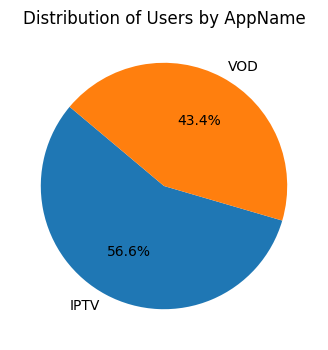

In [17]:
import matplotlib.pyplot as plt

user_per_app_pd = user_per_app.toPandas()

# Plot a pie chart
plt.figure(figsize=(4, 4))
plt.pie(user_per_app_pd["Number of Users"], labels=user_per_app_pd["AppName"], autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Users by AppName")
plt.show()

#### Distribution of Time using App

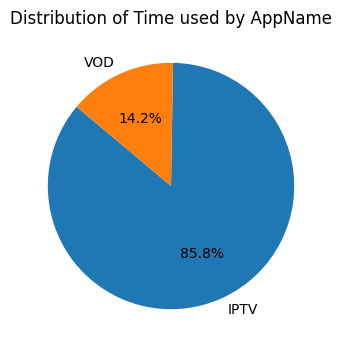

In [18]:
time_per_app = logs_data.groupBy("AppName").agg(sum("RealTimePlaying").alias("Total time used"))
time_per_app_pd = time_per_app.toPandas()

# Plot a pie chart
plt.figure(figsize=(4, 4))
plt.pie(time_per_app_pd["Total time used"], labels=time_per_app_pd["AppName"], autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Time used by AppName")
plt.show()

## Items

#### Top 10 Item with the most users

In [19]:
user_by_item = logs_data.groupBy("ItemId").agg(countDistinct("Mac").alias("Number of Users"))
user_by_item = user_by_item.orderBy(desc("Number of Users"))
user_by_item.show(10)

+------+---------------+
|ItemId|Number of Users|
+------+---------------+
|  NULL|           1693|
|     1|           1440|
|     3|           1296|
|     2|           1251|
|     5|           1142|
|    11|           1056|
|     7|           1048|
|    10|           1045|
|    55|           1024|
|    16|           1024|
+------+---------------+
only showing top 10 rows



#### Top 10 Item with the most time used

In [20]:
time_by_item = logs_data.groupBy("ItemId").agg(sum("RealTimePlaying").alias("Total time used"))
time_by_item = time_by_item.orderBy(desc("Total time used"))
time_by_item.show(10)

+------+--------------------+
|ItemId|     Total time used|
+------+--------------------+
|     1| 4.394428232700002E7|
|    18| 3.359443279099992E7|
|     3|2.8818497228000004E7|
|    62| 2.251839402900001E7|
|   147|      1.8305528402E7|
|    38|1.2242010257000003E7|
|    52|      1.0496772567E7|
|    55|   9775809.384000001|
|     5|   8784024.294999998|
|   181|         8358073.304|
+------+--------------------+
only showing top 10 rows

